In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

## Library Imports & Settings

In [2]:
import numpy as np
import pandas as pd

import scipy
import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter

import pprint

In [3]:
%matplotlib inline

pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 50

## Model Evaluation Tools

_1. Confusion matrix, sensitivity, specificity_

In [4]:
# Build your confusion matrix and calculate sensitivity and specificity here.

def evaluate(y_pred,target):
    conf_data = {'target':target, 'y_pred':y_pred}
    conf_data = pd.DataFrame(data=conf_data)
    
    true_negatives = conf_data.loc[(conf_data['target'] == False) & (conf_data['y_pred'] == False)].shape[0]
    type_II = conf_data.loc[(conf_data['target'] == True) & (conf_data['y_pred'] == False)].shape[0] # False Negatives
    total_negatives = true_negatives + type_II
    
    true_positives = conf_data.loc[(conf_data['target'] == True) & (conf_data['y_pred'] == True)].shape[0]
    type_I = conf_data.loc[(conf_data['target'] == False) & (conf_data['y_pred'] == True)].shape[0] # False Positives
    total_positives = true_positives + type_I
    
    total_positives = conf_data.loc[(conf_data['target'] == True)].shape[0]
    total_negatives = conf_data.loc[(conf_data['target'] == False)].shape[0]
    
    sensitivity = round(true_positives/total_positives*100,2)
    specificity = round(true_negatives/total_negatives*100,2)
    
    confusion_matrix = np.array([[true_negatives, type_II],
                                 [type_I, true_positives]])
   
    output = {'n':conf_data.shape[0],
              'Confusion Matrix':confusion_matrix,
              'Type I':type_I,
              'Type II':type_II,
              'Sensitivity':sensitivity,
              'Specificity':specificity}
    
    return output

_2. K fold cross validation_

In [5]:
def cross_validation(dataframe, k, target, variables):

    frames = np.array_split(dataframe, k)     # Split frame into K folds    
    label = 0     # Number the folds for easier reading
    folds = {} # Create an empty list to hold outputs for each fold
    
    # Create a dataframe to serve as a final output
    summary_frame = pd.DataFrame() 

    # Create lists to house outputs
    fold_id = []
    fold_size = []
    mislabeled = []
    percent_mislabeled = []
    sensitivity = []
    specificity = []
    type_i = []
    type_ii = []
    
    for f in frames:
        
        # Define inputs
        label = label + 1 # Update the label number
        test_data = f[variables] # Create a frame to store test data in
        
        # Create model
        bnb = BernoulliNB() # Instantiate our model and store it in a new variable.
        bnb.fit(test_data, f[target]) # Fit our model to the data.
        y_pred = bnb.predict(test_data) # Classify, storing the result in a new variable.
        f['y_pred'] = y_pred # Add it to our fold

        # Define outputs
        evaluation = evaluate(f['y_pred'], f[target])

        # Append lists
        fold_id.append(label)
        fold_size.append(evaluation['n'])
        mislabeled.append((f[target] != f['y_pred']).sum())
        sensitivity.append(evaluation['Sensitivity'])
        specificity.append(evaluation['Specificity'])
        type_i.append(evaluation['Type I']) 
        type_ii.append(evaluation['Type II'])
        
    
    summary_frame['fold_id'] = fold_id
    summary_frame['fold_size'] = fold_size
    summary_frame['mislabeled'] = mislabeled
    summary_frame['mislabeled_percent'] = summary_frame['mislabeled'] / summary_frame['fold_size']
    summary_frame['sensitivity'] = sensitivity
    summary_frame['specificity'] = specificity
    summary_frame['type_i'] = type_i
    summary_frame['type_ii'] = type_ii
        
    return summary_frame

## Data Cleaning

In [6]:
# Define directories
imdb_txt = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/imdb_labelled.txt"
imdb_txt_cln = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/imdb_labelled_cln.txt"
imdb_csv = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/imdb_labelled_clean.csv"

In [7]:
# Quotation marks in the raw data are causing it to read several rows as one in a few cases
def strip_quotes(txt_dir, txt_cln_dir,):
    with open(txt_dir,'r') as f:
        newlines = []
        for line in f.readlines():
            newlines.append(line.replace('"', ''))     
    
    with open(txt_cln_dir, 'w') as f:
        for line in newlines:
            f.write(line)

_Cleaning the IMDB Data_

In [8]:
# Define directories and parameters; run the cleaning functions
imdb_txt = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/imdb_labelled.txt"
imdb_txt_cln = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/imdb_labelled_cln.txt"
imdb_csv = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/imdb_labelled_clean.csv"

reviews = pd.DataFrame()
imdb_cols = ['review','positive']

# Strip the quotes
strip_quotes(imdb_txt, imdb_txt_cln)

# Create the CSV
with open(imdb_csv,'w') as f:
    for line in open(imdb_txt_cln):
        f.write(line)
    f.close()
reviews = pd.read_csv(imdb_csv, sep="\t", header=None, names=['review','positive'])
reviews.to_csv(imdb_csv, index=False)

# Clean the CSV
reviews['review'] = reviews['review'].apply(lambda x: re.sub('-',' ', str(x))) # separate hyphenated words
reviews['review'] = reviews['review'].apply(lambda x: re.sub('[^\w\s\d]','', str(x))) # strip non-alphanumeric characters
reviews['review'] = reviews['review'].str.lower() # convert all to lowercase

_Spin off the data for multiple iterations of the model_

In [9]:
reviews_iter_1 = reviews.copy()
reviews_iter_2 = reviews.copy()

# Iterations of Model

### 1. Initial Model From Feedback Analysis Challenge (reproduced from u2/l2/p7)

__As we discussed, Wednesday, my initial approach to keyword selection was to create a dataframe summarizing all words from all reviews through the following information:__
1. Counts of the word in positive reviews
2. Counts of the word in negative reviews
3. Counts of the difference in frequency between positive and negative reviews
4. The difference in frequency between positive and negative reviews scaled by the overall frequency of the word.

In [10]:
# create a dataframe containing counts of each word in both positive and negative reviews
words = pd.DataFrame()

In [11]:
# Create a list of all unique words
all_words = []
for rev in reviews['review']:
    for word in rev.split():
        all_words.append(word)        
all_words = set(all_words)

# Retrieve counts of each word for positive reviews
pos_words = []
for rev in reviews['review'].loc[reviews['positive'] == 1]:
    for word in rev.split():
        pos_words.append(word)   
pos_counts = Counter(pos_words)

# Retrieve counts of each word for negative reviews
neg_words = []
for rev in reviews['review'].loc[reviews['positive'] == 0]:
    for word in rev.split():
        neg_words.append(word)         
neg_counts = Counter(neg_words)

In [12]:
# Create a dataframe summarizing words by their frequencies in each type of review
words['word'] = list(all_words)
words = words.set_index('word')

words['pos_count'] = 0
for word in words.index:
    if word in pos_counts:
        words.at[word, 'pos_count'] = pos_counts[word]

words['neg_count'] = 0
for word in words.index:
    if word in neg_counts:
        words.at[word, 'neg_count'] = neg_counts[word]

words['total_count'] = words['pos_count'] + words['neg_count']
        
words['is_positive'] = 0
words.loc[words['neg_count'] < words['pos_count'], 'is_positive'] = 1

words['delta'] = abs(words['pos_count'] - words['neg_count'])

words['scaled_delta'] = words['delta'] / words['total_count']

#### Table of word summaries:

In [13]:
words

,pos_count,neg_count,total_count,is_positive,delta,scaled_delta
word,,,,,,
afraid,2,0,2,1,2,1.00
occur,0,1,1,0,1,1.00
jamie,2,0,2,1,2,1.00
certainly,3,5,8,0,2,0.25
older,1,0,1,1,1,1.00
...,...,...,...,...,...,...
endearing,1,0,1,1,1,1.00
photography,2,0,2,1,2,1.00
himself,1,0,1,1,1,1.00


The idea was that words that had both __a high overall frequency__ and a __high scaled difference__ would be the most impactful to use in my model.

In practice, this didn't work very well. Although I was able to use this method to cut the list down to a few features that had pretty good face validity, it never provided me with a particularly accurate model, and setting the selection critiera (cutoffs for overall frequency and scaled difference) was finicky, arbitrary, and labor intensive. Additionally, it didn't have any built-in method for removing highly correlated features. I tried dozens of iterations of this method, tweaking the values each time, and never got anywhere satisfactory. For the sake of brevity, I've only reproduced one example.

#### Example keywords from first feature selection method:

In [14]:
keywords = []
keywords = list(words.loc[((words['total_count']) > 10) & (words['scaled_delta'] > .8)].index)

print(keywords)

['interesting', 'great', 'worse', 'excellent', 'love', 'awful', 'stupid', 'worst', 'bad', 'wonderful', 'beautiful', 'waste', 'performance', 'terrible']


In [15]:
for key in keywords:
    reviews_iter_1[str(key)] = reviews_iter_1.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [16]:
# Convert target to boolean
reviews_iter_1['positive'] = (reviews_iter_1['positive'] == True)

# Drop text of review
reviews_iter_1 = reviews_iter_1.drop(['review'], axis=1)

#### Correlation heatmap:
The highest correlations between features are relatively small.

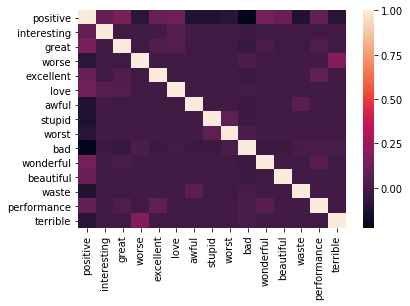

In [17]:
sns.heatmap(reviews_iter_1.corr())
plt.show()

#### Model evaluation:
In summary, not super great. The best result I was able to produce using this method without dramatically overfitting was still only correct about 70% of the time.

In [18]:
data = reviews_iter_1[keywords]
target = reviews_iter_1['positive']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 387


Sensitivity was generally pretty good, but specificity remained abysmal no matter what I did.

In [19]:
validation_iter_1 = evaluate(y_pred, target)
for item in validation_iter_1:
    print('{}: {}'.format(item, validation_iter_1[item]))

n: 1000
Confusion Matrix: [[118   5]
 [382 495]]
Type I: 382
Type II: 5
Sensitivity: 99.0
Specificity: 23.6


#### Cross validation using k-folds:
In addition to having weak performance overall, these features provide us with a wildly inconsistent model. The sensitivity that initially looked pretty good isn't at all consistent across folds.

In [20]:
cross_validation_iter_1 = cross_validation(reviews_iter_1,10,'positive', keywords)
cross_validation_iter_1

,fold_id,fold_size,mislabeled,mislabeled_percent,sensitivity,specificity,type_i,type_ii
0,1,100,38,0.38,100.00,2.56,38,0
1,2,100,19,0.19,9.52,100.00,0,19
2,3,100,33,0.33,26.67,100.00,0,33
3,4,100,31,0.31,100.00,22.50,31,0
4,5,100,34,0.34,25.00,98.21,1,33
5,6,100,23,0.23,14.81,100.00,0,23
6,7,100,23,0.23,100.00,28.12,23,0
7,8,100,35,0.35,98.33,15.00,34,1
8,9,100,38,0.38,21.28,98.11,1,37
9,10,100,22,0.22,100.00,33.33,22,0


In fact, when you summarize the outcomes from each fold, sensitivity and specificity are nearly identical – extremely variable, with a mean of about 60%.

In [21]:
outcomes_iter_1 = ['sensitivity', 'specificity', 'type_i', 'type_ii']

for outcome in outcomes_iter_1:
    outcome_mean = cross_validation_iter_1[outcome].mean()
    outcome_std = cross_validation_iter_1[outcome].std()
    print('{}:\nMean: {}\nStandard Deviation: {}\n'.format(outcome, outcome_mean, outcome_std))

sensitivity:
Mean: 59.561
Standard Deviation: 42.54769283469499

specificity:
Mean: 59.783
Standard Deviation: 42.38727824084329

type_i:
Mean: 15.0
Standard Deviation: 16.076207402383325

type_ii:
Mean: 14.6
Standard Deviation: 16.00833116432399



### 2. Model utilizing k best for feature selection (reproduced from u2/l2/p7)

Again, as we discussed on Wednesday, I eventually settled on feature selection using K best after beating my head against the wall for a while using the method I devised.

#### Narrowing the list of possible features
___Eliminating stop words (as per our conversation on Wednesday)___

In [22]:
import nltk
from nltk.corpus import stopwords

to_drop = stopwords.words('english')
words = words.query('index not in @to_drop')

___Filtering out words with very low frequencies.___

In [23]:
keywords = []
keywords = list(words.loc[((words['total_count']) > 10)].index)

___Filtering out very short words (as per our conversation Wednesday)___

In [24]:
def by_size(words, size):
    return [word for word in words if len(word) > size]

keywords = by_size(keywords, 3)

In [25]:
print(keywords)

['dialogue', 'character', 'interesting', 'time', 'scene', 'best', 'like', 'cant', 'short', 'good', 'right', 'show', 'part', 'doesnt', 'real', 'great', 'dont', 'things', 'years', 'actors', 'script', 'scenes', 'worse', 'line', 'nothing', 'even', 'cast', 'ever', 'movies', 'every', 'excellent', 'totally', 'plot', 'thought', 'little', 'seen', 'make', 'love', 'awful', 'many', 'first', 'really', 'didnt', 'characters', 'ending', 'music', 'recommend', 'stupid', 'still', 'never', 'better', 'movie', 'made', 'thing', 'worst', 'people', 'wonderful', 'acting', 'beautiful', 'funny', 'anyone', 'give', 'could', 'waste', 'performance', 'story', 'would', 'work', 'writing', 'much', 'also', 'everything', 'well', 'film', 'pretty', 'though', 'think', 'enough', 'terrible', 'know', 'films', 'screen', 'watching', 'worth', 'watch', 'look']


___Using select K best to determine a final list of features.___

In [26]:
reviews_k_best = reviews.copy()

# Converting the dataframe to a friendlier format
for key in keywords:
    reviews_k_best[str(key)] = reviews_k_best.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
    
# Convert target to boolean
reviews_k_best['positive'] = (reviews_k_best['positive'] == True)

# Drop text of review
reviews_k_best = reviews_k_best.drop(['review'], axis=1)

In [27]:
selector = SelectKBest(chi2, k=3)
selector.fit(reviews_k_best,reviews_k_best['positive'])

idxs_selected = selector.get_support(indices=True)
reviews_k_best[reviews_k_best.columns[idxs_selected]].head()

,positive,great,wonderful
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,True,False,False


In [28]:
# Setting up the model with the new keywords
keywords = ['positive', 'great', 'wonderful']

for key in keywords:
    reviews_iter_2[str(key)] = reviews_iter_2.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

__Correlation heatmap__

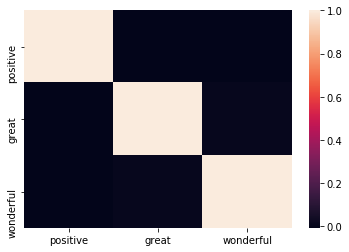

In [29]:
sns.heatmap(reviews_iter_2.corr())
plt.show()

#### Running the final model utilizing these features

In [30]:
data = reviews_iter_2[keywords]
target = reviews_iter_2['positive']

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 1


In [31]:
validation_iter_2 = evaluate(y_pred, target)
for item in validation_iter_2:
    print('{}: {}'.format(item, validation_iter_2[item]))

n: 1000
Confusion Matrix: [[999   1]
 [  0   0]]
Type I: 0
Type II: 1
Sensitivity: 0.0
Specificity: 100.0


__This outcome seems way too good for way too simple a set of features. You suggested that the problem might be overfitting when we spoke on Wednesday – I'm going to test it on a different dataset.__

_Cleaning the Amazon data_

In [32]:
# Define directories and parameters; run the cleaning functions
amazon_txt = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/amazon_cells_labelled.txt"
amazon_txt_cln = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/amazon_cells_labelled_cln.txt"
amazon_csv = r"/Users/guest/Dropbox/Education/Thinkful/Unit 2/l2/s7/sentiment labelled sentences/amazon_cells_labelled_clean.csv"

reviews = pd.DataFrame()
amazon_cols = ['review','positive']

# Strip the quotes
strip_quotes(amazon_txt, amazon_txt_cln)

# Create the CSV
with open(amazon_csv,'w') as f:
    for line in open(amazon_txt_cln):
        f.write(line)
    f.close()
reviews2 = pd.read_csv(amazon_csv, sep="\t", header=None, names=['review','positive'])
reviews2.to_csv(amazon_csv, index=False)

# Clean the CSV
reviews2['review'] = reviews2['review'].apply(lambda x: re.sub('-',' ', str(x))) # separate hyphenated words
reviews2['review'] = reviews2['review'].apply(lambda x: re.sub('[^\w\s\d]','', str(x))) # strip non-alphanumeric characters
reviews2['review'] = reviews2['review'].str.lower() # convert all to lowercase

In [33]:
# Setting up the features in the new dataset
for key in keywords:
    reviews2[str(key)] = reviews2.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [35]:
data = reviews2[keywords]
target = reviews2['positive']

# Instantiate our model and store it in a new variable.
bnb2 = BernoulliNB()

# Fit our model to the data.
bnb2.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb2.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))


Number of mislabeled points out of a total 1000 points : 0
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


# This also seems too good to be true. What's up? I'll ask you about it at our meeting.